In [1]:
import numpy as np
data_a = np.loadtxt('tr1.txt')
data_b = np.loadtxt('tr2.txt')
sample_rate=200.0

t_before=0.05
t_after=0.2
cc_maxlag=0.1

In [2]:
def _pad_zeros(a, num, num2=None):
    """Pad num zeros at both sides of array a"""
    if num2 is None:
        num2 = num
    hstack = [np.zeros(num, dtype=a.dtype), a, np.zeros(num2, dtype=a.dtype)]
    return np.hstack(hstack)

In [5]:
from scipy import signal
import matplotlib.pyplot as plt
import statsmodels.api as sm

# calculate cross correlation
# lag limit upto 12 months

def simple_xcorr(data_a, data_b, samp_rate, cc_maxlag):
    # cross correlate
    #####
    # 入力データのシフト処理（の結果、時系列データの長さが変わってしまう・・・）
    shift_len = int(cc_maxlag * samp_rate)
#     cc = correlate(data_a, data_b, shift_len, method='direct')
    print(data_a)
    dif = len(data_a) - len(data_b) - 2 * shift_len
    if dif > 0:
        data_bb = _pad_zeros(data_b, dif // 2)
        data_aa = data_a.copy()
    else:
        data_aa = _pad_zeros(data_a, -dif // 2)
        data_bb = data_b.copy()
    print(data_aa)
    print(len(data_aa))
    print(len(data_bb))
    ######
    # stattoolsは同じ長さの時系列間の相関しか出せない。代わりにNormalizationまでやってくれる
#     cc = sm.tsa.stattools.ccf(data_a, data_b)[0:12]
    cc = signal.correlate(data_aa, data_bb, mode='valid', method='direct')
    norm = (np.sum(data_aa ** 2) * np.sum(data_bb ** 2)) ** 0.5
    if norm <= np.finfo(float).eps:
        # norm is zero
        # => cross-correlation function will have only zeros
        cc[:] = 0
    elif cc.dtype == float:
        cc /= norm
    else:
        cc = cc / norm
    print(cc)
    
    # _cc_shift, cc_max = xcorr_max(cc)
    cc_curvature = np.concatenate((np.zeros(1), np.diff(cc, 2), np.zeros(1)))
    # cc_convex = np.ma.masked_where(np.sign(cc_curvature) >= 0, cc)
    # cc_concave = np.ma.masked_where(np.sign(cc_curvature) < 0, cc)

    # make array with time shifts in seconds corresponding to cc function
    cc_t = np.linspace(-cc_maxlag, cc_maxlag, shift_len * 2 + 1)

    # take the subportion of the cross correlation around the maximum that is
    # convex and fit a parabola.
    # use vertex as subsample resolution best cc fit.
    peak_index = cc.argmax()
    first_sample = peak_index
    # XXX this could be improved..
    while first_sample > 0 and cc_curvature[first_sample - 1] <= 0:
        first_sample -= 1
    last_sample = peak_index
    while last_sample < len(cc) - 1 and cc_curvature[last_sample + 1] <= 0:
        last_sample += 1

    # work on subarrays
    num_samples = last_sample - first_sample + 1

    # quadratic fit for small subwindow
    coeffs, residual = np.polyfit(
        cc_t[first_sample:last_sample + 1],
        cc[first_sample:last_sample + 1], deg=2, full=True)[:2]

    # X coordinate of vertex of parabola gives time shift to correct
    # differential pick time. Y coordinate gives maximum correlation
    # coefficient.
    dt = -coeffs[1] / 2.0 / coeffs[0]
    coeff = (4 * coeffs[0] * coeffs[2] - coeffs[1] ** 2) / (4 * coeffs[0])
    # this is the shift to apply on the time axis of `trace2` to align the
    # traces. Actually we do not want to shift the trace to align it but we
    # want to correct the time of `pick2` so that the traces align without
    # shifting. This is the negative of the cross correlation shift.
    dt = -dt
    pick2_corr = dt

    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    tmp_t = np.linspace(0, len(data_a) / samp_rate, len(data_a))
    ax1.plot(tmp_t, data_a / float(data_a.max()), "k",
             label="Trace 1")
    ax1.plot(tmp_t, data_b / float(data_b.max()), "r",
             label="Trace 2")
    ax1.plot(tmp_t - dt, data_b / float(data_b.max()),
             "g", label="Trace 2 (shifted)")
    ax1.legend(loc="lower right", prop={'size': "small"})
    ax1.set_xlabel("time [s]")
    ax1.set_ylabel("norm. amplitude")
    ax2 = fig.add_subplot(212)
    # ax2.plot(cc_t, cc_convex, ls="", marker=".", color="k",
    #          label="xcorr (convex)")
    # ax2.plot(cc_t, cc_concave, ls="", marker=".", color="0.7",
    #          label="xcorr (concave)")
    ax2.plot(cc_t[first_sample:last_sample + 1],
             cc[first_sample:last_sample + 1], "b.",
             label="used for fitting")
    tmp_t = np.linspace(cc_t[first_sample], cc_t[last_sample],
                        num_samples * 10)
    ax2.plot(tmp_t, np.polyval(coeffs, tmp_t), "b", label="fit")
    ax2.axvline(-dt, color="g", label="vertex")
    ax2.axhline(coeff, color="g")
    ax2.set_xlabel("%.2f at %.3f seconds correction" % (coeff, -dt))
    ax2.set_ylabel("correlation coefficient")
    ax2.set_ylim(-1, 1)
    ax2.set_xlim(cc_t[0], cc_t[-1])
    ax2.legend(loc="lower right", prop={'size': "x-small"})

[ 6.57423706e+01  6.55519513e+01  6.54534681e+01  6.48025000e+01
  6.30745407e+01  6.00221194e+01  5.57563059e+01  5.06801683e+01
  4.53032495e+01  3.99421407e+01  3.44856220e+01  2.84207649e+01
  2.11194827e+01  1.22238378e+01  1.86080230e+00 -9.37586958e+00
 -2.05147139e+01 -3.04657534e+01 -3.88943025e+01 -4.77715347e+01
 -6.30755349e+01 -9.73399857e+01 -1.79176406e+02 -3.71791237e+02
 -7.74766724e+02 -1.48745231e+03 -2.57187062e+03 -4.04307890e+03
 -5.83431285e+03 -7.72093169e+03 -9.28937797e+03 -9.99826286e+03
 -9.28893295e+03 -6.72056466e+03 -2.12641543e+03  4.25965754e+03
  1.17704150e+04  1.93856832e+04  2.59123641e+04  3.02305006e+04
  3.15392735e+04  2.95233908e+04  2.44017940e+04  1.68684274e+04
  7.93981551e+03 -1.26144749e+03 -9.72079280e+03 -1.66867249e+04
 -2.17490163e+04 -2.48368689e+04 -2.61446769e+04 -2.60095709e+04
 -2.47822651e+04 -2.27376278e+04 -2.00420484e+04 -1.67728991e+04
 -1.29851892e+04 -8.79590152e+03 -4.43355870e+03 -2.14586432e+02
  3.54570878e+03  6.61129

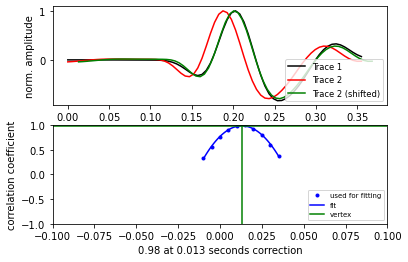

In [6]:
simple_xcorr(data_a, data_b, sample_rate, cc_maxlag)

[ 6.57423706e+01  6.55519513e+01  6.54534681e+01  6.48025000e+01
  6.30745407e+01  6.00221194e+01  5.57563059e+01  5.06801683e+01
  4.53032495e+01  3.99421407e+01  3.44856220e+01  2.84207649e+01
  2.11194827e+01  1.22238378e+01  1.86080230e+00 -9.37586958e+00
 -2.05147139e+01 -3.04657534e+01 -3.88943025e+01 -4.77715347e+01
 -6.30755349e+01 -9.73399857e+01 -1.79176406e+02 -3.71791237e+02
 -7.74766724e+02 -1.48745231e+03 -2.57187062e+03 -4.04307890e+03
 -5.83431285e+03 -7.72093169e+03 -9.28937797e+03 -9.99826286e+03
 -9.28893295e+03 -6.72056466e+03 -2.12641543e+03  4.25965754e+03
  1.17704150e+04  1.93856832e+04  2.59123641e+04  3.02305006e+04
  3.15392735e+04  2.95233908e+04  2.44017940e+04  1.68684274e+04
  7.93981551e+03 -1.26144749e+03 -9.72079280e+03 -1.66867249e+04
 -2.17490163e+04 -2.48368689e+04 -2.61446769e+04 -2.60095709e+04
 -2.47822651e+04 -2.27376278e+04 -2.00420484e+04 -1.67728991e+04
 -1.29851892e+04 -8.79590152e+03 -4.43355870e+03 -2.14586432e+02
  3.54570878e+03  6.61129

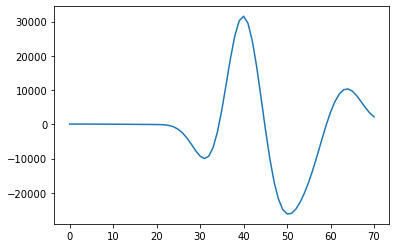

In [8]:
shift_len = int(cc_maxlag * 200)
#     cc = correlate(data_a, data_b, shift_len, method='direct')
print(data_a)
dif = len(data_a) - len(data_b) - 2 * shift_len
if dif > 0:
    data_bb = _pad_zeros(data_b, dif // 2)
    data_aa = data_a.copy()
else:
    data_aa = _pad_zeros(data_a, -dif // 2)
    data_bb = data_b.copy()
print(data_aa)
plt.plot(data_a)

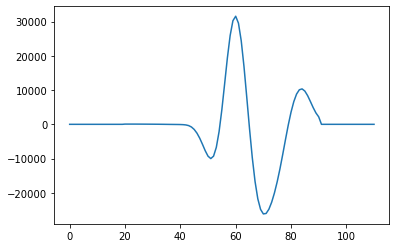

In [9]:
plt.plot(data_aa)

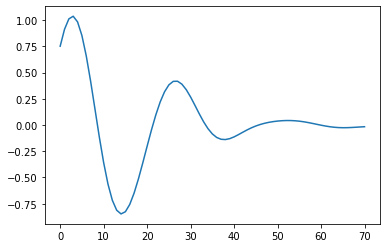

In [13]:
plt.plot(sm.tsa.stattools.ccf(data_a, data_b))

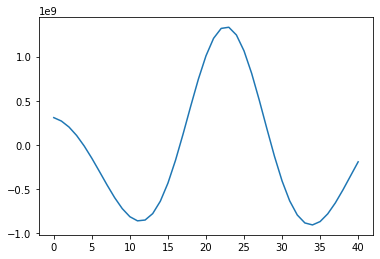

In [14]:
plt.plot(signal.correlate(data_aa, data_bb, mode='valid', method='direct'))

In [38]:
from scipy import signal
import matplotlib.pyplot as plt
import statsmodels.api as sm

# calculate cross correlation
# lag limit upto 12 months

def simple_xcorr(data_a, data_b, samp_rate, cc_maxlag):
    # cross correlate
    shift_len = int(cc_maxlag * samp_rate)
#     cc = correlate(data_a, data_b, shift_len, method='direct')
    cc = sm.tsa.stattools.ccf(data_a, data_b)[0:12]
    print(cc)
#     cc = signal.correlate(data_aa, data_bb, mode='valid', method='direct')
    # _cc_shift, cc_max = xcorr_max(cc)
    cc_curvature = np.concatenate((np.zeros(1), np.diff(cc, 2), np.zeros(1)))
    # cc_convex = np.ma.masked_where(np.sign(cc_curvature) >= 0, cc)
    # cc_concave = np.ma.masked_where(np.sign(cc_curvature) < 0, cc)

    # make array with time shifts in seconds corresponding to cc function
    cc_t = np.linspace(-cc_maxlag, cc_maxlag, shift_len * 2 + 1)

    # take the subportion of the cross correlation around the maximum that is
    # convex and fit a parabola.
    # use vertex as subsample resolution best cc fit.
    peak_index = cc.argmax()
    first_sample = peak_index
    # XXX this could be improved..
    while first_sample > 0 and cc_curvature[first_sample - 1] <= 0:
        first_sample -= 1
    last_sample = peak_index
    while last_sample < len(cc) - 1 and cc_curvature[last_sample + 1] <= 0:
        last_sample += 1

    # work on subarrays
    num_samples = last_sample - first_sample + 1

    # quadratic fit for small subwindow
    coeffs, residual = np.polyfit(
        cc_t[first_sample:last_sample + 1],
        cc[first_sample:last_sample + 1], deg=2, full=True)[:2]

    # X coordinate of vertex of parabola gives time shift to correct
    # differential pick time. Y coordinate gives maximum correlation
    # coefficient.
    dt = -coeffs[1] / 2.0 / coeffs[0]
    coeff = (4 * coeffs[0] * coeffs[2] - coeffs[1] ** 2) / (4 * coeffs[0])
    # this is the shift to apply on the time axis of `trace2` to align the
    # traces. Actually we do not want to shift the trace to align it but we
    # want to correct the time of `pick2` so that the traces align without
    # shifting. This is the negative of the cross correlation shift.
    dt = -dt
    pick2_corr = dt

    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    tmp_t = np.linspace(0, len(data_a) / samp_rate, len(data_a))
    ax1.plot(tmp_t, data_a / float(data_a.max()), "k",
             label="Trace 1")
    ax1.plot(tmp_t, data_b / float(data_b.max()), "r",
             label="Trace 2")
    ax1.plot(tmp_t - dt, data_b / float(data_b.max()),
             "g", label="Trace 2 (shifted)")
    ax1.legend(loc="lower right", prop={'size': "small"})
    ax1.set_xlabel("time [s]")
    ax1.set_ylabel("norm. amplitude")
    ax2 = fig.add_subplot(212)
    # ax2.plot(cc_t, cc_convex, ls="", marker=".", color="k",
    #          label="xcorr (convex)")
    # ax2.plot(cc_t, cc_concave, ls="", marker=".", color="0.7",
    #          label="xcorr (concave)")
    ax2.plot(cc_t[first_sample:last_sample + 1],
             cc[first_sample:last_sample + 1], "b.",
             label="used for fitting")
    tmp_t = np.linspace(cc_t[first_sample], cc_t[last_sample],
                        num_samples * 10)
    ax2.plot(tmp_t, np.polyval(coeffs, tmp_t), "b", label="fit")
    ax2.axvline(-dt, color="g", label="vertex")
    ax2.axhline(coeff, color="g")
    ax2.set_xlabel("%.2f at %.3f seconds correction" % (coeff, -dt))
    ax2.set_ylabel("correlation coefficient")
    ax2.set_ylim(-1, 1)
    ax2.set_xlim(cc_t[0], cc_t[-1])
    ax2.legend(loc="lower right", prop={'size': "x-small"})

[ 0.75052608  0.91167784  1.01102192  1.03617997  0.98221866  0.85250734
  0.65840146  0.41779182  0.1527651  -0.1132179  -0.35814351 -0.56381216]


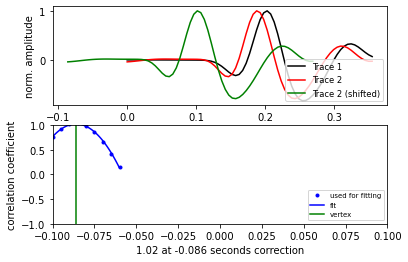

In [39]:
simple_xcorr(data_a, data_b, sample_rate, cc_maxlag)